# SVM and Logistic Regression with PyTorch Implementation
In this exercise, we explore a machine learning framework, namely PyTorch. We will use the framework to implement SVM and Logistic Regression models and address a multi-class image classification problem.

# Submission
- Report the results and answer the questions in a pdf file.
- Additionally, submit your code in the same Jupiter notebook format. (keep the overal format of the notebook unchanged)
- The submission deadline on A2L is Nov 16, 11pm.


In [60]:
# To supress some warning messages while using parralel processing
import warnings
from urllib3.exceptions import InsecureRequestWarning
warnings.filterwarnings("ignore", category=InsecureRequestWarning)

In [61]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Dataset characteristics
We use the MNIST digit classification data set for this assignment.
A total of 60K images for training and 10K images for testing are available. Images are 28 x 28 pixels.

In [62]:
# Download datasets
train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
print(train_set)
print(test_set)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [63]:
train_set.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [64]:
# Add dataset to pytorch DataLoader with mini-batch size 64 s.t. each batch contains 64 images.
train_loader = DataLoader(train_set, batch_size=64, shuffle=False)

# Get first batch of images and labels
train_image_batch, classe_set = next(iter(train_loader))

print(f'train_loader contains {len(train_loader)} batches of data.')
print(f'train_image_batch has shape {train_image_batch.shape},')
print('where 64 is the number of images in a batch, 1 is the number of image channels (1 for grayscale image),\
 28X28 stands for WxH (width and height of a single image).')

train_loader contains 938 batches of data.
train_image_batch has shape torch.Size([64, 1, 28, 28]),
where 64 is the number of images in a batch, 1 is the number of image channels (1 for grayscale image), 28X28 stands for WxH (width and height of a single image).


# Visualization of dataset

In [65]:
def show_gray_digits(image_set, row=2, col=3):
  # Here we visualize some of the data points in the data set.
  # Create a large figure, to be filled with multiple subplots.

  # Since image_set is a tensor variable, we transform it to a numpy type variable.
  image_set = image_set.cpu().detach().numpy()

  for i in range(row*col):
    # define subplot
    plt.subplot(row, col, i+1)
    # plot raw pixel data
    plt.imshow(image_set[i,0], cmap=plt.get_cmap('gray'))
  # show the figure
  plt.show()

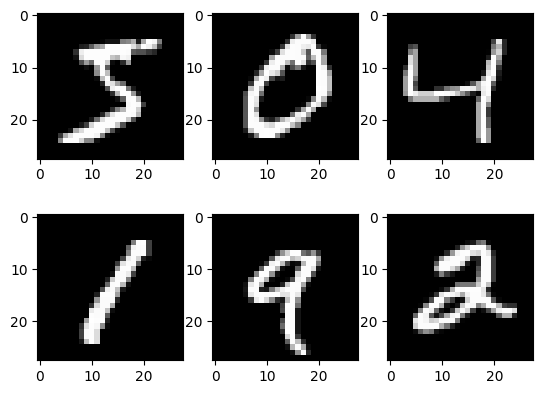

tensor([5, 0, 4, 1, 9, 2])


In [66]:
# display images and their corresponding labels.
show_gray_digits(train_image_batch, 2, 3)
print(classe_set[:6])
del train_image_batch, classe_set, train_set, train_loader, test_set

# Task 1: Linear SVM for MNIST classification (30 points).
In this part, you are provided with the implementation of a multi-class linear SVM model and the basic MNIST classfication workflow. Run the given code and try to understand how it works.

**A (5 points)**. Is the implementation of the multi-class linear SVM similar to the end-to-end multiclass SVM that we learned in the class? Are there any significant differences?


**B (15 points)**. Modify the program to
1. Modify the code to compute the accuracy on the train and test set after each epoch in the training. Plot these accuracies as a function of the epoch number.

2. Modify the code to compute the hinge loss on the train and test set after each epoch in the training. Plot these loss values as a function of the epoch number.

3. Does the model shows significant overfitting? Or do you think there might be other factors that are more significant in the mediocre performance of the model?


# A

The implementation of the multi class linear SVM presented seems similar to the standard end to end multiclass SVM. It uses a linear layer to map input features to class scores and a multi margin loss. There might be differences in the specific optimization and regularization details but the fundamental idea remains consistent with the multiclass SVM approach taught in class

# B

In [67]:
# Load MNIST datasets, and create pytorch data loader to read data in mini-batches
def get_data_loaders(learning_rate, batch_size):
  transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

  train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
  test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)
  test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

  return train_loader, test_loader

# Plot test/train loss values/accuracies against the number of epochs.
# Set description to 'Loss' or 'Accuracy' based on the use scenario.
def plot_eval_results(train_log, test_log, description='Loss'):
  x = np.arange(0, len(train_log))

  plt.figure(figsize=(6, 4))
  plt.plot(x, train_log, color='b',  label='train')  # Plot some data on the axes.
  plt.plot(x, test_log, color='r',  label='test')  # Plot some data on the axes.
  plt.xlabel('#Epochs')  # Add an x-label to the axes.
  plt.ylabel(description)  # Add a y-label to the axes.
  plt.title("Report")  # Add a title to the axes.
  plt.legend()  # Add a legend.

  plt.show()

In [68]:
# Return model loss and accuracy with the provided criterion and data_loader.
def test(model, data_loader, criterion=None):
  model.eval()
  correct = 0
  total = 0
  loss_batches = []

  # Switch to evaluation mode and turn off gradient calculation
  # since parameters are not updated during testing.
  with torch.no_grad():
      for images_batch, labels_batch in data_loader:
          outputs = model(images_batch)
          # The predicted label is the output with the highest activation.
          _, predicted = torch.max(outputs.data, 1)
          total += labels_batch.size(0)
          correct += (predicted == labels_batch).sum().item()

          # Use provided criterion to calculate the loss for the mini batch
          # Append the mini-batch loss to loss_batches array
          # To do
          # (See the example of calculating loss in the next code block)

          batch_loss = criterion(outputs, labels_batch)
          loss_batches.append(batch_loss.item())

  accuracy = 100 * correct / total
  loss = np.mean(loss_batches) if loss_batches else float('nan')

  model.train()

  return accuracy, loss

Epoch [1/5], Step [100/938], Loss: 0.07665043324232101
Epoch [1/5], Step [200/938], Loss: 0.06705708801746368
Epoch [1/5], Step [300/938], Loss: 0.06518084555864334
Epoch [1/5], Step [400/938], Loss: 0.04926130175590515
Epoch [1/5], Step [500/938], Loss: 0.07490844279527664
Epoch [1/5], Step [600/938], Loss: 0.06114303693175316
Epoch [1/5], Step [700/938], Loss: 0.053190406411886215
Epoch [1/5], Step [800/938], Loss: 0.022865183651447296
Epoch [1/5], Step [900/938], Loss: 0.04689091071486473
Epoch 1 - Train loss on the MNIST test set : 0.05410545617977439
Epoch 1 - Train accuracy on the MNIST test set : 89.36%
Epoch 1 - Test loss on the MNIST test set : 0.12806838971509296
Epoch 1 - Test accuracy on the MNIST test set : 80.47%
Epoch [2/5], Step [100/938], Loss: 0.03197920322418213
Epoch [2/5], Step [200/938], Loss: 0.052818652242422104
Epoch [2/5], Step [300/938], Loss: 0.02514348179101944
Epoch [2/5], Step [400/938], Loss: 0.04248133301734924
Epoch [2/5], Step [500/938], Loss: 0.01443

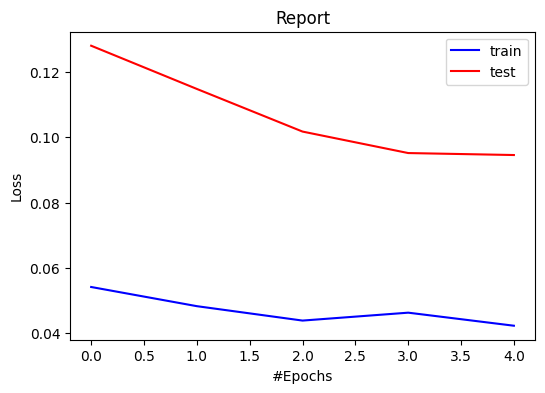

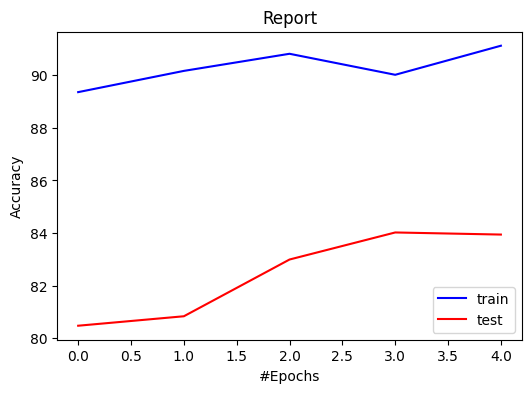

In [69]:
# Define a linear SVM model
class LinearSVM(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LinearSVM, self).__init__()
        self.fc = nn.Linear(input_size, num_classes, bias=True)

    def forward(self, x):
        # Flatten the image
        x= x.view(-1, 28*28)
        return self.fc(x)

# Define loss function (A Multi-class version of Hinge loss)
criterion = nn.MultiMarginLoss()

# Hyperparameters
# Learning rate controls the step size of gradient descent
learning_rate = 0.01
# Number of epochs controls how many rounds of training will be done
num_epochs = 5
# Batch size controls the number of images in each mini-batch
batch_size = 64

# Load MNIST dataset
train_loader, test_loader = get_data_loaders(learning_rate, batch_size)

# Initialize the SVM model
input_size = 28 * 28  # MNIST image size
num_classes = 10  # Number of classes in MNIST
model = LinearSVM(input_size, num_classes)

# Optimizer (Stochastic Gradient Descent method)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Training
train_loss_epochs = []
test_loss_epochs = []
train_accuracy_epochs = []
test_accuracy_epochs = []

for epoch in range(num_epochs):
    for i, (images_batch, labels_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(images_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()

        # outputs are class predictions of the input images
        outputs = model(images_batch)
        loss = criterion(outputs, labels_batch)

        # Calculate and update model parameters
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item()}')

    train_accuracy, train_loss = test(model, train_loader, criterion)
    test_accuracy, test_loss = test(model, test_loader, criterion)
    # Call test function after each epoch
    # Obtain train/test loss values and accuracies
    # To Do

    print(f'Epoch {epoch+1} - Train loss on the MNIST test set : {train_loss}')
    print(f'Epoch {epoch+1} - Train accuracy on the MNIST test set : {train_accuracy:.2f}%')
    print(f'Epoch {epoch+1} - Test loss on the MNIST test set : {test_loss}')
    print(f'Epoch {epoch+1} - Test accuracy on the MNIST test set : {test_accuracy:.2f}%')
    train_loss_epochs.append(train_loss)
    test_loss_epochs.append(test_loss)
    train_accuracy_epochs.append(train_accuracy)
    test_accuracy_epochs.append(test_accuracy)

# Call plot_eval_results function to plot train/test loss values and accuracies
plot_eval_results(train_loss_epochs, test_loss_epochs, description='Loss')
plot_eval_results(train_accuracy_epochs, test_accuracy_epochs, description='Accuracy')

# 3


**C (10 points)**. Weight decay works like regularization. Set weight decay to one of the values (0.002, 0.02, 0.2) during defining the SGD optimizer (see  [SGD optimizer documentation](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) for how to do that). Plot the train/test accuracies per epoch. Does weight decay help in this case?Justify the results.


For weight decay value 0.002:


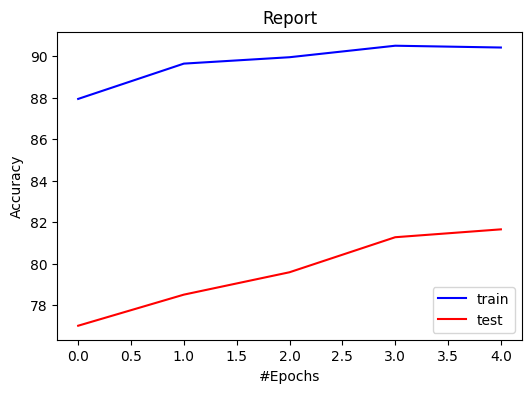

For weight decay value 0.02:


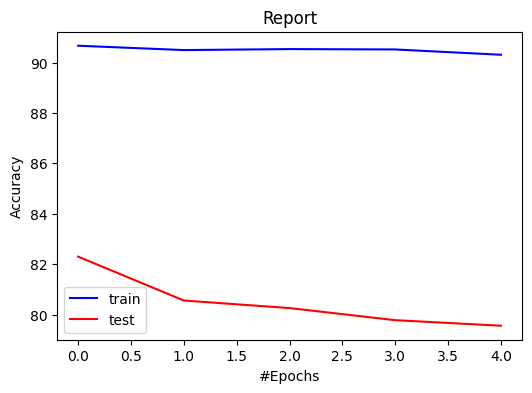

For weight decay value 0.2:


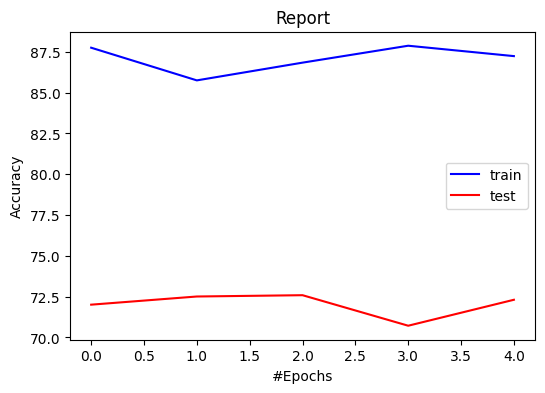

In [70]:
model = LinearSVM(input_size, num_classes)

train_loader, test_loader = get_data_loaders(learning_rate, batch_size)

for weight_decay in [0.002, 0.02, 0.2]:
    # Add weight decay to SGD optimizer
    # To Do
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    train_accuracy_epochs = []
    test_accuracy_epochs = []

    # Train model and obtain train/test accuracy after each epoch
    # To do
    for epoch in range(num_epochs):
        model.train()
        for i, (images_batch, labels_batch) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images_batch)
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()

        train_accuracy, _ = test(model, train_loader, criterion)
        train_accuracy_epochs.append(train_accuracy)

        test_accuracy, _ = test(model, test_loader, criterion)
        test_accuracy_epochs.append(test_accuracy)

    # Plot accuracies
    print(f'For weight decay value {weight_decay}:')
    plot_eval_results(train_accuracy_epochs, test_accuracy_epochs, description='Accuracy')

# Justify the results
From the results shown in the graphs it seems as the model with the best weight decay is 0,002. The higher weight decays does have a higher gap between the training and test results, this indicates that the models are overfitting. But considering that a weight decay of 0,02 also shows some promising results could indicate that the optimal weight decay could be placed between 0,002 and 0,02, this would have to be confirmed with testing. 

# Task 2: Logistic Regression for MNIST classification  (20 points).
In this part, you are asked to implement a logistic regression model for the same MNIST classfication problem.

**A (5 points)**. Use Cross Entropy Loss (rather than Hinge Loss) to implement logistic regression.

**B (10 points)**.
1. Compute the accuracy on the train and test set after each epoch in the training. Plot these accuracies as a function of the epoch number.

2. Compute the cross-entropy loss on the train and test set after each epoch in the training. Plot these loss values as a function of the epoch number.

3. Does the model shows significant overfitting? Or do you think there might be other factors that are more significant in the mediocre performance of the model?

**C (5 points)**
Compare the results with SVM model. Does it work better, worse, or similar?

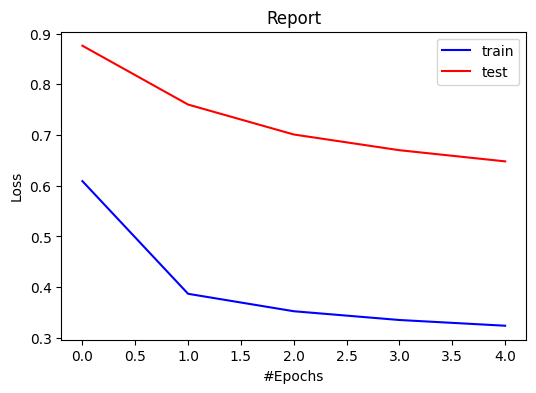

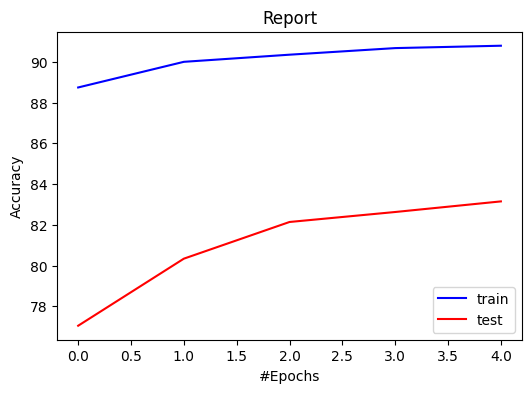

In [71]:
# Logistic Regression model
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.fc = nn.Linear(input_size, num_classes, bias=True)

    def forward(self, x):
        # Flatten the image
        x= x.view(-1, 28*28)
        return self.fc(x)

# Define cross entropy loss
# To Do
criterion = nn.CrossEntropyLoss()

input_size = 28 * 28 
num_classes = 10 
model = LogisticRegression(input_size, num_classes)

learning_rate = 0.01
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Train logistic regression model for MNIST classification
# Obtain train/test accuracies/loss values after each epoch
# To do
def calculate_accuracy(loader, model):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.view(-1, 28*28)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

num_epochs = 5
train_loss_epochs = []
test_loss_epochs = []
train_accuracy_epochs = []
test_accuracy_epochs = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    train_loss_epochs.append(train_loss / len(train_loader))
    train_accuracy = calculate_accuracy(train_loader, model)
    train_accuracy_epochs.append(train_accuracy)

    test_loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
    test_loss_epochs.append(round(test_loss / len(test_loader), 3))
    test_accuracy = calculate_accuracy(test_loader, model)
    test_accuracy_epochs.append(round(test_accuracy, 3))

plot_eval_results(train_loss_epochs, test_loss_epochs, description='Loss')
plot_eval_results(train_accuracy_epochs, test_accuracy_epochs, description='Accuracy')

# 3
Any overfitting in the model, is shown as the gap between the test and training accuracy, with a gap of almost 10% it could indicate that the model indeed has some problems with high varians in the dataset. The gap in the both loss and accuracy could be the cause of not enough generalization or that the model is too complex for the amount of training data available.


# C



# Task 3: Non-linearity (25 points)
**A (15 points)**. Add a hidden layer with 100 neurons and a RELU layer for both logistic regression and SVM models in Task 1 and Task 2.
1. For both models, plot the train loss and the test loss.
2. For both models, plot the train and test accuracies.


**B (10 points)**
Which approach works better? Why? Explain your findings and justify it.

In [72]:
# Both the SVM and Logistic Regression models we have in Task 1 and 2
# can be changed to the ModifiedModel below.

input_size = 28 * 28  # MNIST image size
num_classes = 10  # Number of classes in MNIST
hidden_size = 100  # Number of neurons in the hidden layer

# Modified model with added neurons and relu layer
class ModifiedModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ModifiedModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28*28) 
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

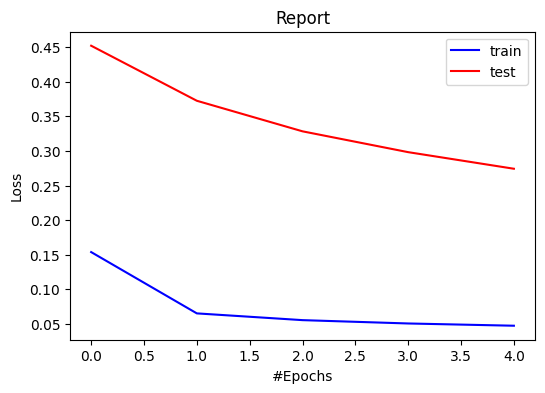

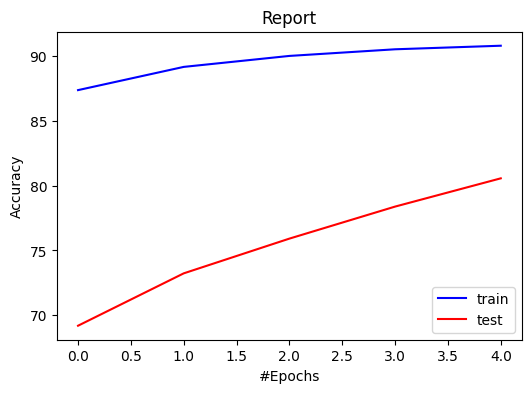

In [73]:
# Run the ModifiedModel with Hinge Loss (SVM)
# Define criterion and model
# To do
criterion_svm = nn.MultiMarginLoss()
model_svm = ModifiedModel(input_size, hidden_size, num_classes)
optimizer_svm = optim.SGD(model_svm.parameters(), lr=learning_rate)


# Train ModifiedModel for MNIST classification
# Obtain train/test accuracies/loss values after each epoch
# To do
train_loss_epochs_svm = []
test_loss_epochs_svm = []
train_accuracy_epochs_svm = []
test_accuracy_epochs_svm = []

# Training loop
for epoch in range(num_epochs):
    model_svm.train() 
    train_loss_svm = 0
    for images, labels in train_loader:
        images = images.view(-1, 28*28) 
        labels = labels

        outputs = model_svm(images)
        loss = criterion_svm(outputs, labels)

        optimizer_svm.zero_grad()
        loss.backward()
        optimizer_svm.step()

        train_loss_svm += loss.item()

    train_loss_epochs_svm.append(train_loss_svm / len(train_loader))
    train_accuracy_epochs_svm.append(calculate_accuracy(train_loader, model_svm))

    model_svm.eval()
    test_loss_svm = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(-1, 28*28)
            outputs = model_svm(images)
            loss = criterion_svm(outputs, labels)
            test_loss_svm += loss.item()

    test_loss_epochs_svm.append(test_loss_svm / len(test_loader))
    test_accuracy_epochs_svm.append(calculate_accuracy(test_loader, model_svm))

plot_eval_results(train_loss_epochs_svm, test_loss_epochs_svm, description='Loss')
plot_eval_results(train_accuracy_epochs_svm, test_accuracy_epochs_svm, description='Accuracy')

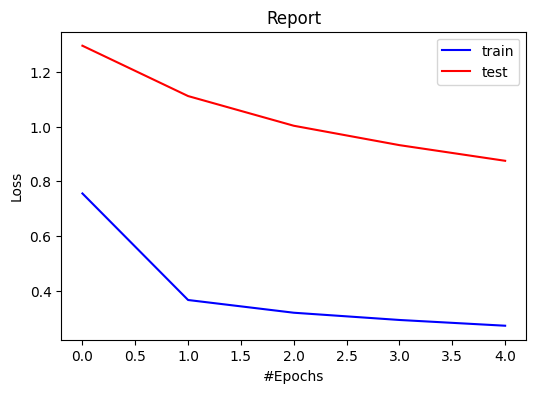

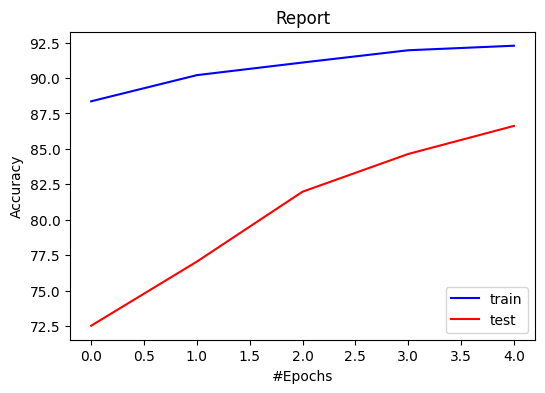

In [74]:
# Run the ModifiedModel with Cross Entropy Loss (Logistic Regression)
# Define criterion and model
# To do
criterion = nn.CrossEntropyLoss()
model = ModifiedModel(input_size, hidden_size, num_classes)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Train ModifiedModel for MNIST classification
# Obtain train/test accuracies/loss values after each epoch
# To do
train_loss_epochs = []
test_loss_epochs = []
train_accuracy_epochs = []
test_accuracy_epochs = []

# Training loop
for epoch in range(num_epochs):
    model.train()  
    train_loss = 0
    for images, labels in train_loader:
        images = images.view(-1, 28*28) 
        labels = labels

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss_epochs.append(train_loss / len(train_loader))
    train_accuracy_epochs.append(calculate_accuracy(train_loader, model))


    model.eval()
    test_loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(-1, 28*28) 
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

    test_loss_epochs.append(test_loss / len(test_loader))
    test_accuracy_epochs.append(calculate_accuracy(test_loader, model))


plot_eval_results(train_loss_epochs, test_loss_epochs, description='Loss')
plot_eval_results(train_accuracy_epochs, test_accuracy_epochs, description='Accuracy')

# B

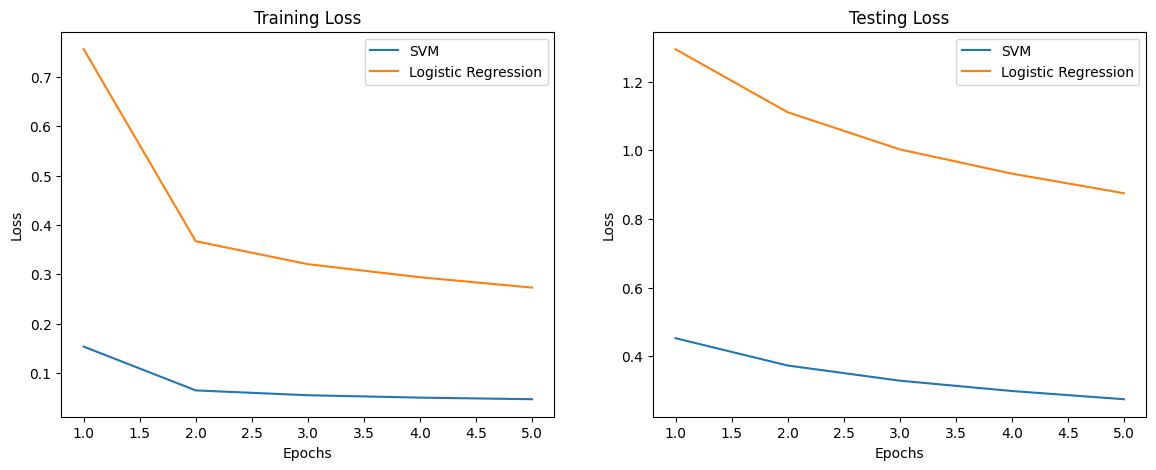

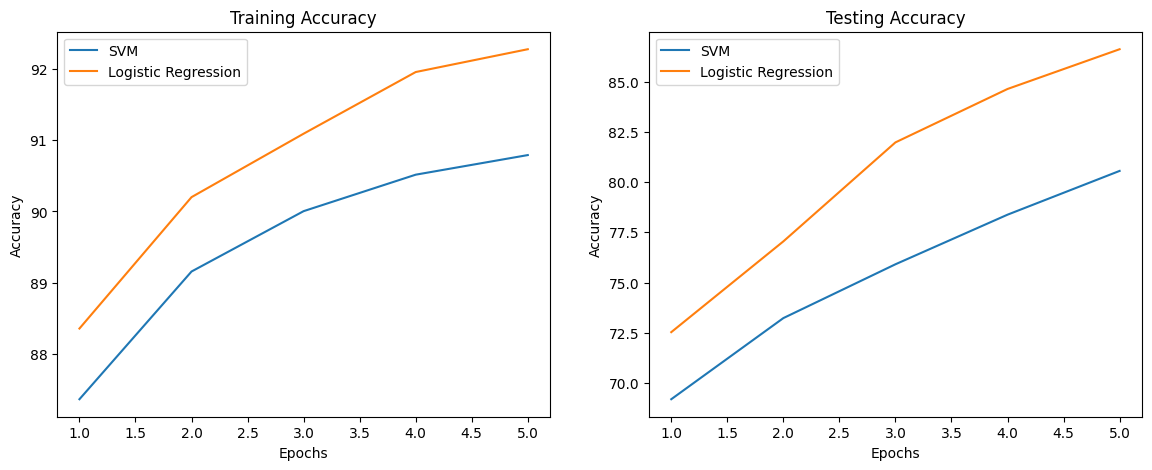

In [75]:
def plot_eval_results_comparison(train_svm, test_svm, train_lr, test_lr, description):
    epochs_range = range(1, num_epochs + 1)
    plt.figure(figsize=(14, 5))

    # Plot training results
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_svm, label='SVM')
    plt.plot(epochs_range, train_lr, label='Logistic Regression')
    plt.title(f'Training {description}')
    plt.xlabel('Epochs')
    plt.ylabel(description)
    plt.legend()

    # Plot testing results
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, test_svm, label='SVM')
    plt.plot(epochs_range, test_lr, label='Logistic Regression')
    plt.title(f'Testing {description}')
    plt.xlabel('Epochs')
    plt.ylabel(description)
    plt.legend()

    plt.show()

plot_eval_results_comparison(
    train_loss_epochs_svm, test_loss_epochs_svm,
    train_loss_epochs, test_loss_epochs,
    'Loss'
)

plot_eval_results_comparison(
    train_accuracy_epochs_svm, test_accuracy_epochs_svm,
    train_accuracy_epochs, test_accuracy_epochs,
    'Accuracy'
)

In [76]:
#Print accuracy of the SVM and Logistic Regression models
print(f'Accuracy of SVM model: {train_accuracy_epochs_svm[-1]}')
print(f'Accuracy of Logistic Regression model: {train_accuracy_epochs[-1]}')


Accuracy of SVM model: 90.79
Accuracy of Logistic Regression model: 92.275


Given that the cross entropy loss from the logistic regression is higher than the hinge loss from the SVM it indicates that the loss function is less certain of its classifications than the SVM. But even tough the loss for cross entropy is higher, the logistic regression still manages to have a higher accuracy in both training and testing accuracy. This indicates that the following the high loss and high accuracy the logistic regression has a few big errors in classifying the data, while the SVM has a lot of small errors in the classification. The accuracy can be accredited to the fact the accuracy measures correctness not confidence.


So given that the deciding factor is the how well the models predict on the unseen testing data, it is clear that the logistic Regression is the better approch to this data set.

# Task 4 (25 points):
We want to play around with the previous part's approach and improve it. Try changing the hyperparameters such as learning rate, number of epochs, number of hidden neurons, weight decay factor, loss function, etc. Report the best configuration that you found (in terms of the test accuracy) along with the train and test accuracies for it.

# It takes 8 min to find the best configuration 

In [77]:
def train_and_evaluate_model(model, criterion, optimizer, num_epochs, train_loader, test_loader):
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []

    # Early stopping parameters
    patience = 10
    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images = images.view(-1, 28*28) 
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_loss_epochs.append(avg_train_loss)
        train_accuracy = calculate_accuracy(train_loader, model)
        train_accuracy_epochs.append(train_accuracy)

        model.eval()
        test_loss = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.view(-1, 28*28) 
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

        avg_test_loss = test_loss / len(test_loader)
        test_loss_epochs.append(avg_test_loss)
        test_accuracy = calculate_accuracy(test_loader, model)
        test_accuracy_epochs.append(test_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Train Accuracy: {train_accuracy:.4f}, "
              f"Test Loss: {avg_test_loss:.4f}, "
              f"Test Accuracy: {test_accuracy:.4f}")

        # Early stopping check
        if avg_test_loss < best_loss:
            best_loss = avg_test_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    return train_loss_epochs, test_loss_epochs, train_accuracy_epochs, test_accuracy_epochs

In [78]:
# Hyperparameters
learning_rates = [1e-3, 1e-4]
hidden_sizes = [50, 100]
decays = [1e-5, 1e-4]
batch_sizes = [32, 64]

# Store the best configuration, accuracy, and loss
best_accuracy = 0
best_loss = float('inf')
best_train_loss = None
best_config = None

# Store the losses for the best configuration
best_train_loss_epochs = []
best_test_loss_epochs = []

for lr in learning_rates:
    for hidden_size in hidden_sizes:
        for decay in decays:
            for batch_size in batch_sizes:
                train_loader, test_loader = get_data_loaders(lr, batch_size)

                model = ModifiedModel(28 * 28, hidden_size, 10)
                optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
                criterion = torch.nn.CrossEntropyLoss()

                train_loss_epochs, test_loss_epochs, train_accuracy_epochs, test_accuracy_epochs = train_and_evaluate_model(
                    model, criterion, optimizer, 5, train_loader, test_loader
                )

                best_epoch_index = np.argmax(test_accuracy_epochs)
                best_epoch_test_accuracy = test_accuracy_epochs[best_epoch_index]
                best_epoch_test_loss = test_loss_epochs[best_epoch_index]

                if best_epoch_test_accuracy > best_accuracy:
                    best_accuracy = best_epoch_test_accuracy
                    best_loss = best_epoch_test_loss
                    best_train_loss = train_loss_epochs[best_epoch_index]
                    best_config = {
                        'lr': lr,
                        'hidden_size': hidden_size,
                        'decay': decay,
                        'batch_size': batch_size,
                        'accuracy': best_epoch_test_accuracy
                    }
                    best_train_loss_epochs = train_loss_epochs
                    best_test_loss_epochs = test_loss_epochs

print("Best Configuration:")
print(best_config)
print(f"Best Train Loss: {best_train_loss:.4f}")
print(f"Best Test Loss: {best_loss:.4f}")

Epoch 1/5 - Train Loss: 0.4178, Train Accuracy: 91.0933, Test Loss: 0.7920, Test Accuracy: 86.2600
Epoch 2/5 - Train Loss: 0.2488, Train Accuracy: 93.0683, Test Loss: 0.5392, Test Accuracy: 91.6300
Epoch 3/5 - Train Loss: 0.2002, Train Accuracy: 95.1117, Test Loss: 0.4900, Test Accuracy: 90.9700
Epoch 4/5 - Train Loss: 0.1716, Train Accuracy: 95.4967, Test Loss: 0.4231, Test Accuracy: 92.4500
Epoch 5/5 - Train Loss: 0.1557, Train Accuracy: 95.7850, Test Loss: 0.3755, Test Accuracy: 93.2300
Epoch 1/5 - Train Loss: 0.4450, Train Accuracy: 90.8817, Test Loss: 0.8683, Test Accuracy: 86.9300
Epoch 2/5 - Train Loss: 0.2721, Train Accuracy: 93.0683, Test Loss: 0.6489, Test Accuracy: 90.2800
Epoch 3/5 - Train Loss: 0.2111, Train Accuracy: 94.7533, Test Loss: 0.5029, Test Accuracy: 93.0200
Epoch 4/5 - Train Loss: 0.1750, Train Accuracy: 95.0317, Test Loss: 0.4158, Test Accuracy: 93.8400
Epoch 5/5 - Train Loss: 0.1540, Train Accuracy: 95.3267, Test Loss: 0.3634, Test Accuracy: 94.2600
Epoch 1/5 

# The results Vary
Best Configuration:
{'lr': 0.001, 'hidden_size': 100, 'decay': 1e-05, 'batch_size': 32, 'accuracy': 95.79}
Best Train Loss: 0.1374
Best Test Loss: 0.2464

I get about a 3% increase in accuracy from the logistic regression